In [63]:
import pandas as pd
import datetime as dt
import numpy as np

In [64]:
df = pd.read_csv('flex.csv')

In [65]:
#finding indices that have 'test' strings
filtered_indices = df[(df['company_name'].str.contains('test', case=False)) |
                                           (df['fullname'].str.contains('test', case=False)) |
                                           (df['email'].str.contains('test', case=False)) |
                                           (df['promotion_code'].str.contains('test', case=False)) |
                                           (df['partner_name'].str.contains("test", case=False))].index

#dropping 'test' strings from indices of the df
fdf = df.drop(filtered_indices)

In [66]:
fdf = fdf[fdf['source'].isin(['WL', 'FM'])]

In [67]:
fdf = fdf[fdf['status'] == 'paid']

In [68]:
fdf.describe()

,ds_out_of_policy_request_id,total_price,sub_total,discounted_amount,tax_amount,total_price_in_usd,processing_fee_in_usd,to_usd_rate,order_line_item_total_price,add_on_days_to_expire,capacity,start_time,end_time,quantity
count,0.0,23132.000000,23132.000000,23132.000000,23132.000000,23132.000000,23132.000000,23132.000000,23124.000000,3000.000000,20103.000000,3151.000000,3151.000000,23124.000000
mean,NaN,199.999902,176.280747,-9.900359,23.719155,105.408681,2.819339,0.831134,184.290845,48.165000,2.952296,1147.565852,1475.858458,1.184311
std,NaN,366.425824,316.656709,71.705957,53.439123,149.460545,4.254518,0.353257,338.226323,23.792782,25.632377,234.704969,222.166856,0.699883
min,NaN,0.640000,0.540000,-3715.000000,0.000000,0.680000,0.000000,0.198240,0.540000,30.000000,1.000000,330.000000,630.000000,1.000000
25%,NaN,35.000000,32.000000,0.000000,0.000000,34.820000,1.170000,0.306968,32.000000,30.000000,1.000000,930.000000,1300.000000,1.000000
50%,NaN,70.800000,70.000000,0.000000,5.130000,47.965000,1.610000,1.000000,70.000000,30.000000,1.000000,1100.000000,1500.000000,1.000000
75%,NaN,175.500000,150.000000,0.000000,23.000000,118.105000,3.030000,1.043240,160.000000,60.000000,1.000000,1330.000000,1700.000000,1.000000
max,NaN,9009.000000,7700.000000,0.000000,1309.000000,3125.000000,116.300000,1.405630,7700.000000,180.000000,1000.000000,1800.000000,2000.000000,20.000000


Looking at the operators and measure their success in terms of how many orders they've fufilled and how much revenue was generated. 

In [69]:
# Total sales revenue for each partner
partner_revenue = fdf.groupby('partner_name')['total_price_in_usd'].sum()

# Total number of orders for each partner
partner_orders = fdf['partner_name'].value_counts()

# Merge these metrics into a new DataFrame
success_df = pd.DataFrame({'Total Revenue': partner_revenue, 'Total Orders': partner_orders})

Normalizing the scales, range 0 to 1, to have a fair comparison between each feature, otherwise Total Revenue would likely dominate the success_score.

After normalizing, adding a bit more weight to the monteary value to match real life scenarios

In [70]:
# Normalize the metrics to have the same scale
success_df = (success_df - success_df.min()) / (success_df.max() - success_df.min())

# Define a new column 'success_score' which is a weighted sum of your defined metrics
success_df['success_score'] = 0.6 * success_df['Total Revenue'] + 0.4 * success_df['Total Orders'] 

# Sort partners by 'success_score'
success_df = success_df.sort_values('success_score', ascending=False)

# Rename 'index' to 'partner_name'
success_df.rename(columns={'index': 'partner_name'}, inplace=True)

In [71]:
success_df

,Total Revenue,Total Orders,success_score
Mindspace,1.000000,1.000000,1.000000
WeWork Israel,0.906840,0.469941,0.732080
The Yard,0.364797,0.372261,0.367782
The Malin,0.348390,0.149056,0.268656
Werqwise,0.157764,0.060874,0.119008
Luminary,0.115587,0.086454,0.103934
Nomadworks,0.093988,0.101241,0.096889
Urban Place,0.079151,0.068969,0.075078
Brain Embassy,0.056930,0.065947,0.060537
Bond Collective,0.043920,0.043281,0.043665


Based off of these success_scores, Mindspace and WeWork Israel are by far the more successful operators. It may be imortant to check out Coalition Space to as to why their Total Revenue is basically 0. 

As to initial observations why these operators are successful, I'd like to know if there is a correlation between the kind of promotions the operators offer and their success_score. 

Counting the number of promotions_codes per partner_name will show how often each partner allowed the customer use a promotion to make a transaction. Then merging this into the Data Frame will begin to reveal if there may be a correlation between the two. 

In [72]:
# Frequency of promotion code usage among successful and unsuccessful partners
promotion_usage = fdf.groupby('partner_name')['promotion_code'].count()

# Merge this metric into your success_df DataFrame
success_df['Promotion Usage'] = promotion_usage

# Check correlation between 'Promotion Usage' and 'success_score'
correlation = success_df['Promotion Usage'].corr(success_df['success_score'])

In [73]:
success_df.sort_values('Promotion Usage', ascending=False)

,Total Revenue,Total Orders,success_score,Promotion Usage
Mindspace,1.000000,1.000000,1.000000,1289
WeWork Israel,0.906840,0.469941,0.732080,638
Luminary,0.115587,0.086454,0.103934,332
The Malin,0.348390,0.149056,0.268656,71
Werqwise,0.157764,0.060874,0.119008,61
ROOMS,0.040528,0.029250,0.036017,41
The Yard,0.364797,0.372261,0.367782,16
Brain Embassy,0.056930,0.065947,0.060537,12
Nomadworks,0.093988,0.101241,0.096889,9
gSpace,0.001867,0.000324,0.001250,5


In [74]:
correlation

0.9144547568375859

A correlation close to 1 shows a strong positive linear relationship. This means that partners who use promotions more frequently tend to have higher success scores. However, correlation does not imply causation. While the correlation value indicates a strong relationship, it does not definitively prove that using more promotions causes a partner to be more successful.

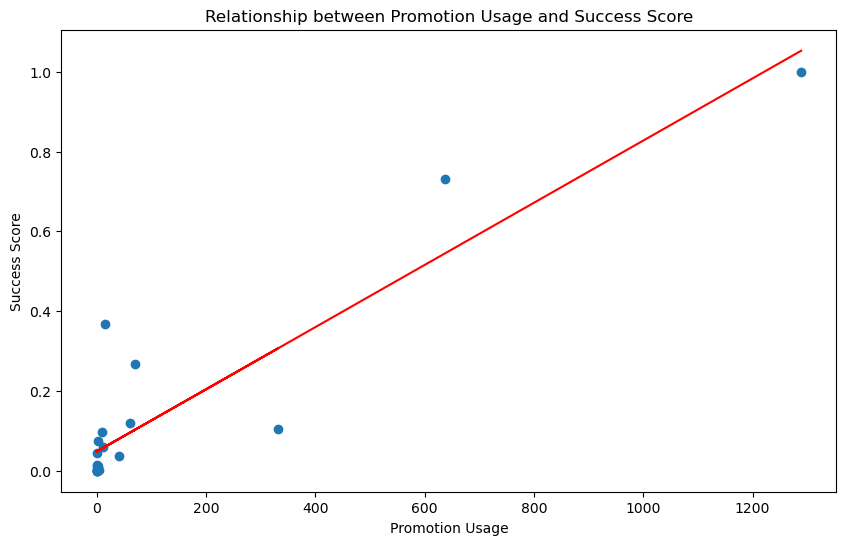

In [75]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.scatter(success_df['Promotion Usage'], success_df['success_score'])
plt.title('Relationship between Promotion Usage and Success Score')
plt.xlabel('Promotion Usage')
plt.ylabel('Success Score')

# plot a line of best fit
m, b = np.polyfit(success_df['Promotion Usage'], success_df['success_score'], 1)
plt.plot(success_df['Promotion Usage'], m*success_df['Promotion Usage'] + b, color='red')

plt.show()

I'm interested to see the geographical success scores for the operators 

First, it's important to merge the success_scores dataframe with the initial dataframe so we can see each operator's success score along with all of the other data. 

In [77]:
# Reset the index and rename it to 'partner_name'
success_df.reset_index(inplace=True)
success_df.rename(columns={'index': 'partner_name'}, inplace=True)

# Merge the original dataframe with the success dataframe on 'partner_name'
merged_df = pd.merge(fdf, success_df[['partner_name', 'success_score']], on='partner_name')

In [89]:
# Group by partner_name, country, state, and city, then calculate the mean success score for each group
geo_success_df = merged_df.groupby(['partner_name', 'country', 'city'])['success_score'].mean().reset_index()

# Find the partner with the highest success score in each country, state, and city
most_successful_partners = geo_success_df.loc[geo_success_df.groupby(['country', 'city'])['success_score'].idxmax()]

most_successful_partners

,partner_name,country,city,success_score
14,Mindspace,DE,Berlin,1.000000
15,Mindspace,DE,Frankfurt,1.000000
16,Mindspace,DE,Hamburg,1.000000
17,Mindspace,DE,Munich,1.000000
18,Mindspace,GB,London,1.000000
52,WeWork Israel,IL,Be'er Sheva,0.732080
35,ROOMS,IL,Bnei Brak,0.036017
19,Mindspace,IL,Haifa,1.000000
20,Mindspace,IL,Herzliya,1.000000
55,WeWork Israel,IL,Jerusalem,0.732080


This is a macro look actoss the globe. It will be better to look at the success_score on a country level in order to get a better idea how successful each operator is. 